In [1]:
! pip install classification-models-3D

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 kB 669.8 kB/s eta 0:00:0000:010:01


In [2]:
!pip install keras_applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 546.6 kB/s eta 0:00:00a 0:00:01


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import nibabel as nib
from tensorflow import keras
import tensorflow_addons as tfa
import random
from scipy import ndimage
from tensorflow import keras
import os

In [4]:
df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")

In [5]:
n_image_list = np.arange(0, df.shape[0])
random_n_image_list = np.random.choice(n_image_list, df.shape[0], replace=False)

In [6]:
def data_gen():
    df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")
    for i in random_n_image_list[:1800]:
        path = "../input/cervical-ct-preprocessing/" + str(df.iloc[i]["StudyInstanceUID"]) +".nii.gz"
        try:
            ct = nib.load(path)
            ct = ct.get_fdata()
            for pic in range(34,94):
                yield ({"input_1": np.stack([ct[pic,:,:],ct[pic,:,:],ct[pic,:,:]],axis=-1)}, 
                       {'co': df.iloc[i]["patient_overall"], 
                                        'c1': df.iloc[i]["C1"],
                                        'c2': df.iloc[i]["C2"],
                                        'c3': df.iloc[i]["C3"],
                                        'c4': df.iloc[i]["C4"],
                                        'c5': df.iloc[i]["C5"],
                                        'c6': df.iloc[i]["C6"],
                                        'c7': df.iloc[i]["C7"],})
                
        except:
            continue

            
            
def test_gen():
    df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")
    for i in random_n_image_list[1800:]:
        path = "../input/cervical-ct-preprocessing/" + str(df.iloc[i]["StudyInstanceUID"]) +".nii.gz"
        try:
            ct = nib.load(path)
            ct = ct.get_fdata()
            for pic in range(34, 94):
                yield ({"input_1": np.stack([ct[pic,:,:],ct[pic,:,:],ct[pic,:,:]],axis=-1)}, 
                       {'co': df.iloc[i]["patient_overall"], 
                                        'c1': df.iloc[i]["C1"],
                                        'c2': df.iloc[i]["C2"],
                                        'c3': df.iloc[i]["C3"],
                                        'c4': df.iloc[i]["C4"],
                                        'c5': df.iloc[i]["C5"],
                                        'c6': df.iloc[i]["C6"],
                                        'c7': df.iloc[i]["C7"],})
        except:
            continue

In [7]:
dataset = tf.data.Dataset.from_generator(
     data_gen,
     ({"input_1":tf.float32}, 
     {'co':tf.int8,
     'c1':tf.int8,
     'c2':tf.int8,
     'c3':tf.int8,
     'c4':tf.int8,
     'c5':tf.int8,
     'c6':tf.int8,
     'c7':tf.int8}),
    ({"input_1":tf.TensorShape([128,128,3])}, 
     {"co": tf.TensorShape([]), 
     "c1": tf.TensorShape([]),
     "c2": tf.TensorShape([]),
     "c3": tf.TensorShape([]),
     "c4": tf.TensorShape([]),
     "c5": tf.TensorShape([]),
     "c6": tf.TensorShape([]),
     "c7": tf.TensorShape([])})
)

testset = tf.data.Dataset.from_generator(
     test_gen,
     ({"input_1":tf.float32}, 
     {'co':tf.int8,
     'c1':tf.int8,
     'c2':tf.int8,
     'c3':tf.int8,
     'c4':tf.int8,
     'c5':tf.int8,
     'c6':tf.int8,
     'c7':tf.int8}),
    ({"input_1":tf.TensorShape([128,128,3])}, 
     {"co": tf.TensorShape([]), 
     "c1": tf.TensorShape([]),
     "c2": tf.TensorShape([]),
     "c3": tf.TensorShape([]),
     "c4": tf.TensorShape([]),
     "c5": tf.TensorShape([]),
     "c6": tf.TensorShape([]),
     "c7": tf.TensorShape([])})
)

2022-10-08 07:33:08.613526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 07:33:08.725540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 07:33:08.726730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 07:33:08.734072: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
dataset = (
    dataset.batch(40)
    .prefetch(1)
)

testset = (
    testset.batch(40)
    .prefetch(1)
)

2022-10-08 07:33:11.959307: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Exception ignored in: <generator object data_gen at 0x7f3575b8add0>
RuntimeError: generator ignored GeneratorExit


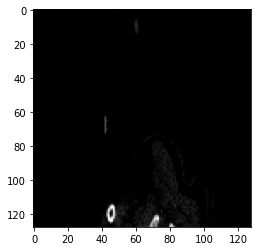

In [9]:
for i in dataset.take(4):
    plt.imshow(i[0]["input_1"][0])

In [10]:
res = tf.keras.applications.ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3),
)

171458560/171446536 [==============================] - 2s 0us/step


In [11]:
inputs = keras.Input((128, 128, 3), name = "input_1")

features = res(inputs)

x = keras.layers.Flatten()(features)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(8, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)

outputo = keras.layers.Dense(1 ,activation = 'sigmoid', name="co")(x)
output1 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c1")(x)
output2 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c2")(x)
output3 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c3")(x)
output4 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c4")(x)
output5 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c5")(x)
output6 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c6")(x)
output7 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c7")(x)
                                               
model = keras.models.Model(inputs=inputs, outputs=[outputo,output1,output2,output3,output4,output5,output6,output7, features])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
resnet101 (Functional)          (None, 4, 4, 2048)   42658176    input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 32768)        0           resnet101[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32768)        131072      flatten[0][0]                    
______________________________________________________________________________________________

In [13]:
opt = tfa.optimizers.AdamW(
    weight_decay=2e-4,
    learning_rate = 0.0009,
    beta_1 = 0.9,
    beta_2 = 0.999,
    epsilon = 1e-07,
    name = 'AdamW',
)
loss = tf.keras.losses.BinaryCrossentropy(
    label_smoothing=0.1, 
    reduction=tf.keras.losses.Reduction.AUTO,
    name='binary_crossentropy'
)
metrics = [tf.keras.metrics.AUC()]
model.compile(optimizer=opt,
              loss={"co": loss, 
                   "c1": loss,
                   "c2": loss,
                   "c3": loss,
                   "c4": loss,
                   "c5": loss,
                   "c6": loss,
                   "c7": loss,},
                metrics={"co": metrics, 
                   "c1": metrics,
                   "c2": metrics,
                   "c3": metrics,
                   "c4": metrics,
                   "c5": metrics,
                   "c6": metrics,
                   "c7": metrics,})


In [15]:
history = model.fit(dataset, validation_data = testset, epochs=2)

2699/2699 [==============================] - 712s 264ms/step - loss: 3.4753 - co_loss: 0.6929 - c1_loss: 0.3615 - c2_loss: 0.4642 - c3_loss: 0.2781 - c4_loss: 0.3144 - c5_loss: 0.3693 - c6_loss: 0.4556 - c7_loss: 0.5394 - c7_c6_c5_c4_c3_c2_c1_co_auc: 0.7522 - val_loss: 3.6947 - val_co_loss: 0.6957 - val_c1_loss: 0.3369 - val_c2_loss: 0.4976 - val_c3_loss: 0.3521 - val_c4_loss: 0.3861 - val_c5_loss: 0.3983 - val_c6_loss: 0.5250 - val_c7_loss: 0.5030 - val_c7_c6_c5_c4_c3_c2_c1_co_auc: 0.7180


In [53]:
def data_gen2():
    df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")
    for i in random_n_image_list[:1800]:
        path = "../input/cervical-ct-preprocessing/" + str(df.iloc[i]["StudyInstanceUID"]) +".nii.gz"
        try:
            ct = nib.load(path)
            ct = ct.get_fdata()
            
            extracted_features = res(tf.stack([ct,ct,ct],axis=-1)[34:94,...])


            s = keras.layers.Reshape((-1,2048))(extracted_features)
            
            yield ({"input_1": s}, 
                   {'co': df.iloc[i]["patient_overall"], 
                                    'c1': df.iloc[i]["C1"],
                                    'c2': df.iloc[i]["C2"],
                                    'c3': df.iloc[i]["C3"],
                                    'c4': df.iloc[i]["C4"],
                                    'c5': df.iloc[i]["C5"],
                                    'c6': df.iloc[i]["C6"],
                                    'c7': df.iloc[i]["C7"],})
                
        except:
            continue

            
            
def test_gen2():
    df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")
    for i in random_n_image_list[1800:]:
        path = "../input/cervical-ct-preprocessing/" + str(df.iloc[i]["StudyInstanceUID"]) +".nii.gz"
        try:
            ct = nib.load(path)
            ct = ct.get_fdata()
            extracted_features = res(tf.stack([ct,ct,ct],axis=-1)[34:94,...])

            s = keras.layers.Reshape((-1,2048))(extracted_features)
            
            yield ({"input_1": s}, 
                   {'co': df.iloc[i]["patient_overall"], 
                                    'c1': df.iloc[i]["C1"],
                                    'c2': df.iloc[i]["C2"],
                                    'c3': df.iloc[i]["C3"],
                                    'c4': df.iloc[i]["C4"],
                                    'c5': df.iloc[i]["C5"],
                                    'c6': df.iloc[i]["C6"],
                                    'c7': df.iloc[i]["C7"],})
            
        except:
            continue

In [75]:
dataset2 = tf.data.Dataset.from_generator(
     data_gen2,
     ({"input_1":tf.float32}, 
     {'co':tf.int8,
     'c1':tf.int8,
     'c2':tf.int8,
     'c3':tf.int8,
     'c4':tf.int8,
     'c5':tf.int8,
     'c6':tf.int8,
     'c7':tf.int8}),
    ({"input_1":tf.TensorShape([60,16,2048])}, 
     {"co": tf.TensorShape([]), 
     "c1": tf.TensorShape([]),
     "c2": tf.TensorShape([]),
     "c3": tf.TensorShape([]),
     "c4": tf.TensorShape([]),
     "c5": tf.TensorShape([]),
     "c6": tf.TensorShape([]),
     "c7": tf.TensorShape([])})
)

testset2 = tf.data.Dataset.from_generator(
     test_gen2,
     ({"input_1":tf.float32}, 
     {'co':tf.int8,
     'c1':tf.int8,
     'c2':tf.int8,
     'c3':tf.int8,
     'c4':tf.int8,
     'c5':tf.int8,
     'c6':tf.int8,
     'c7':tf.int8}),
    ({"input_1":tf.TensorShape([60,16,2048])}, 
     {"co": tf.TensorShape([]), 
     "c1": tf.TensorShape([]),
     "c2": tf.TensorShape([]),
     "c3": tf.TensorShape([]),
     "c4": tf.TensorShape([]),
     "c5": tf.TensorShape([]),
     "c6": tf.TensorShape([]),
     "c7": tf.TensorShape([])})
)

In [76]:
dataset2 = (
    dataset2.batch(20)
    .prefetch(1)
)

testset2 = (
    testset2.batch(20)
    .prefetch(1)
)

In [30]:
"a"

'a'

In [83]:
inputs = keras.Input((60, 16, 2048),name = "input_1")

s = keras.layers.Reshape((-1,2048))(inputs)
s = keras.layers.BatchNormalization()(s)
s = keras.layers.Bidirectional(keras.layers.LSTM(2048, return_sequences=True))(s)
s = keras.layers.Dense(2048, activation='relu')(s)
s = keras.layers.BatchNormalization()(s)
s = keras.layers.Bidirectional(keras.layers.LSTM(2048, return_sequences=False))(s)
s = keras.layers.BatchNormalization()(s)
s = keras.layers.Dense(512, activation='relu')(s)
s = keras.layers.Dense(128, activation='relu')(s)
s = keras.layers.Dense(32, activation='relu')(s)
outputo = keras.layers.Dense(1 ,activation = 'sigmoid', name="co")(s)
output1 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c1")(s)
output2 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c2")(s)
output3 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c3")(s)
output4 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c4")(s)
output5 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c5")(s)
output6 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c6")(s)
output7 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c7")(s)
                                               
s_model = keras.models.Model(inputs=inputs, outputs=[outputo,output1,output2,output3,output4,output5,output6,output7])

In [84]:
s_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 16, 2048 0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 960, 2048)    0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 960, 2048)    8192        reshape_5[0][0]                  
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 960, 4096)    67125248    batch_normalization_14[0][0]     
____________________________________________________________________________________________

In [85]:
opt = tfa.optimizers.AdamW(
    weight_decay=1e-4,
    learning_rate = 0.005,
    beta_1 = 0.9,
    beta_2 = 0.999,
    epsilon = 1e-07,
    name = 'AdamW',
)
loss = tf.keras.losses.BinaryCrossentropy(
#     label_smoothing=0.1, 
    reduction=tf.keras.losses.Reduction.AUTO,
    name='binary_crossentropy'
)
metrics = [tf.keras.metrics.AUC()]
s_model.compile(optimizer=opt,
              loss={"co": loss, 
                   "c1": loss,
                   "c2": loss,
                   "c3": loss,
                   "c4": loss,
                   "c5": loss,
                   "c6": loss,
                   "c7": loss,},
                metrics={"co": metrics, 
                   "c1": metrics,
                   "c2": metrics,
                   "c3": metrics,
                   "c4": metrics,
                   "c5": metrics,
                   "c6": metrics,
                   "c7": metrics,})

In [86]:
!mkdir final_model

mkdir: cannot create directory ‘final_model’: File exists


In [87]:
model_checkpoint_callback_LASSO = tf.keras.callbacks.ModelCheckpoint(
    filepath = './final_model/model',
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
)

In [88]:
history = s_model.fit(dataset2, validation_data = testset2, epochs=10, callbacks=[model_checkpoint_callback_LASSO])

Epoch 1/10


Exception ignored in: <generator object data_gen2 at 0x7f34e49f8150>
RuntimeError: generator ignored GeneratorExit


90/90 [==============================] - 867s 10s/step - loss: 3.6648 - co_loss: 0.9364 - c1_loss: 0.3332 - c2_loss: 0.5155 - c3_loss: 0.1934 - c4_loss: 0.2774 - c5_loss: 0.3270 - c6_loss: 0.5103 - c7_loss: 0.5715 - c7_c6_c5_c4_c3_c2_c1_co_auc_6: 0.6832 - val_loss: 60.8814 - val_co_loss: 12.6143 - val_c1_loss: 3.8293 - val_c2_loss: 6.8974 - val_c3_loss: 5.8928 - val_c4_loss: 6.9963 - val_c5_loss: 5.2993 - val_c6_loss: 10.9729 - val_c7_loss: 8.3791 - val_c7_c6_c5_c4_c3_c2_c1_co_auc_6: 0.5000
Epoch 2/10
90/90 [==============================] - 904s 10s/step - loss: 3.0457 - co_loss: 0.7286 - c1_loss: 0.2902 - c2_loss: 0.4182 - c3_loss: 0.1501 - c4_loss: 0.2034 - c5_loss: 0.3532 - c6_loss: 0.4012 - c7_loss: 0.5008 - c7_c6_c5_c4_c3_c2_c1_co_auc_6: 0.7379 - val_loss: 37.6839 - val_co_loss: 3.7910 - val_c1_loss: 3.8677 - val_c2_loss: 2.7116 - val_c3_loss: 4.0992 - val_c4_loss: 3.8327 - val_c5_loss: 4.0505 - val_c6_loss: 10.0391 - val_c7_loss: 5.2919 - val_c7_c6_c5_c4_c3_c2_c1_co_auc_6: 0.500

In [89]:
s_model.load_weights("./final_model/model")

In [91]:
!mkdir saved_final_model

In [92]:
s_model.save("./saved_final_model/s_model")

2022-10-08 11:59:11.451693: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [94]:
!mkdir model_2d

mkdir: cannot create directory ‘model_2d’: File exists


In [95]:
model.save("./model_2d/model")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
